In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp

from lvmdrp.functions import imageMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}

In [2]:
frames_table = md.get_metadata(tileid="*", mjd=60177)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: found 522 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5'
[INFO]: number of frames after filtering 522
[INFO]: total number of frames found 522


In [3]:
masters_mjd = frames_table.mjd.min()
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")

In [4]:
masters_flat = md.get_metadata(kind="master", imagetyp="flat").query("mjd == @masters_mjd").sort_values("camera")
masters_flat

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: found 102 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 18
[INFO]: total number of frames found 18


tileid    mjd   rmjd imagetyp spec camera  exptime   neon   hgne  krypton  \
12    1111  60177  60177     flat  sp1     b1    150.0  False  False    False   
14    1111  60177  60177     flat  sp2     b2    150.0  False  False    False   
10    1111  60177  60177     flat  sp3     b3    150.0  False  False    False   
16    1111  60177  60177     flat  sp1     r1    150.0  False  False    False   
11    1111  60177  60177     flat  sp2     r2    150.0  False  False    False   
15    1111  60177  60177     flat  sp3     r3    150.0  False  False    False   
13    1111  60177  60177     flat  sp1     z1     10.0  False  False    False   
9     1111  60177  60177     flat  sp2     z2     10.0  False  False    False   
17    1111  60177  60177     flat  sp3     z3     10.0  False  False    False   

    ...  argon   ldls  quartz    quality qual  stage  status  drpqual  \
12  ...  False   True   False  excellent    0      1       0        0   
14  ...  False   True   False  excellent    0      1       0        0   
10  ...  False   True   False  excellent    0      1       0        0   
16  ...  False   True   False  excellent    0      1       0        0   
11  ...  False   True   False  excellent    0      1       0        0   
15  ...  False   True   False  excellent    0      1       0        0   
13  ...  False  False    True  excellent    0      1       0        0   
9   ...  False  False    True  excellent    0      1       0        0   
17  ...  False  False    True  excellent    0      1       0        0   

    nframes                 name  
12        2    lvm-mflat_ldls-b1  
14        2    lvm-mflat_ldls-b2  
10        2    lvm-mflat_ldls-b3  
16        2    lvm-mflat_ldls-r1  
11        2    lvm-mflat_ldls-r2  
15        2    lvm-mflat_ldls-r3  
13        2  lvm-mflat_quartz-z1  
9         2  lvm-mflat_quartz-z2  
17        2  lvm-mflat_quartz-z3  

[9 rows x 21 columns]

In [5]:
mtrace_paths = []
for flat in masters_flat.to_dict("records"):
    camera = flat["camera"]
    
    lamp = MASTER_CON_LAMPS[camera[0]]
    if lamp == "ldls":
        counts_threshold = 20
    elif lamp == "quartz":
        counts_threshold = 1000
    
    # define master continuum exposure path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"mflat_{lamp}", camera=camera)
    # define master trace path
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mtrace_paths.append(mtrace_path)

    if os.path.isfile(mtrace_path):
        print(f"skipping {mtrace_path}, file already exist")
        continue
    
    # trace peak of fibers
    imageMethod.trace_peaks(in_image=mflat_path, out_trace=mtrace_path, steps=30, coadd=5,
                            threshold=counts_threshold, max_diff=1.5, method="gauss", median_box=10,
                            correct_ref=True, median_cross=1, poly_disp=4, write_trace_data=False, display_plots=True)

# cache new masters metadata into HDF5 files
# new_masters = md.extract_metadata(frames_paths=mtrace_paths)
# md.add_masters(new_masters)

skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-b1.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-b2.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-b3.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-r1.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-r2.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-r3.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-z1.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-z2.fits, file already exist
skipping /home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mtrace-z3.fits, file already exist


[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
[WARNING]: overflow encountered in cast (RuntimeWarning)


>>>>>>>>>>>> 0 4.0
[4004.0906  3998.538   3992.9856  3987.4045  3981.8228  3976.23
 3970.6257  3965.078   3959.4468  3953.8762  3948.3862  3942.666
 3937.0745  3931.496   3925.9932  3920.39    3914.6096  3909.1743
 3903.5422  3897.9858  3892.4026  3886.815   3881.1174  3875.5615
 3870.091   3864.4783  3858.8093  3853.3064  3847.6404  3842.2012
 3836.522   3830.807   3825.333   3819.6882  3814.1448  3808.669
 3790.662   3784.9976  3779.5278  3773.849   3768.3645  3762.705
 3757.0396  3751.5244  3745.9817  3740.3533  3734.7222  3729.217
 3723.609   3717.8828  3712.4146  3706.806   3701.2651  3695.6013
 3690.0195  3684.547   3678.9148  3673.2444  3667.717   3662.2192
 3656.5557  3650.8975  3645.4011  3639.805   3634.2825  3628.6047
 3623.1018  3617.3726  3611.6985  3606.15    3600.621   3595.1875
 3576.3975  3570.8877  3565.24    3559.7864  3554.0452  3548.4524
 3542.9153  3537.311   3531.7964  3526.2622  3520.5977  3515.0925
 3509.4478  3503.8516  3498.2688  3492.6409  3487.064   3481.41

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in scalar divide (RuntimeWarning)


fitted FWHM:  [1.50070429e+01 9.01995773e+01 2.19349174e+01 9.05092907e+00
 1.74684105e+01 1.58424835e+01 7.27634277e+02 5.05648918e+01
 1.73068657e+01 1.11839952e+01 1.00926352e+01 4.62683563e+02
 3.46856567e+02 1.27394733e+01 1.72069702e+01 2.40920273e+02
 9.90067261e+02 1.13255854e+01 1.50631647e+01 1.76139240e+01
 1.69889221e+01 4.84501724e+01 9.12998867e+00 9.55134216e+02
 2.10113182e+01 5.22251404e+02 2.19463257e+02 3.27194672e+02
 1.33874359e+01 1.11177692e+01 1.05851545e+01 3.13483093e+02
 6.00556870e+01 1.72387123e+01 1.17205849e+01 9.72382927e+00
 1.45811405e+01 1.08331451e+01 2.01807194e+01 1.79848160e+02
 1.99488468e+01 9.39863777e+00 8.19148064e+00 4.59334351e+02
 1.36756620e+01 1.53973637e+01 1.40360651e+01 1.02255280e+03
 8.75490723e+02 1.86879425e+01 1.67188759e+01 2.30138493e+01
 4.30705078e+02 3.37834015e+01 1.73881226e+01 5.10650970e+02
 1.35509892e+01 2.33261013e+01 1.48057318e+01 2.99637661e+01
 1.99764385e+01 1.01008319e+03 1.58084211e+01 1.19660358e+01
 6.9823516

[WARNING]: invalid value encountered in sqrt (RuntimeWarning)


>>>>>>>>>>>> 0 4.0
[4009.6975  4004.1614  3998.6252  3993.0942  3987.54    3981.9124
 3976.418   3970.775   3965.22    3959.6396  3954.1707  3948.5632
 3942.8643  3937.382   3931.8489  3926.1802  3920.545   3915.0073
 3909.4238  3903.9402  3898.2913  3892.8088  3887.0872  3881.502
 3876.0796  3870.426   3864.8574  3859.2898  3853.6843  3848.2515
 3842.4946  3836.8638  3831.3274  3825.7258  3820.2117  3814.7278
 3796.6013  3791.02    3785.5144  3779.8337  3774.3582  3768.6428
 3763.0317  3757.5212  3752.0002  3746.388   3740.7144  3735.2078
 3729.6226  3723.856   3718.4165  3712.787   3707.1628  3701.615
 3695.9443  3690.515   3684.8787  3679.1064  3673.6743  3668.1145
 3662.488   3656.8643  3651.2505  3645.752   3640.133   3634.4695
 3628.9443  3623.199   3617.5798  3611.9941  3606.4517  3600.999
 3582.101   3576.4988  3570.8943  3565.3838  3559.7053  3554.0615
 3548.4888  3542.921   3537.3286  3531.8083  3526.145   3520.5762
 3514.9165  3509.328   3503.7046  3498.0562  3492.4226  3486

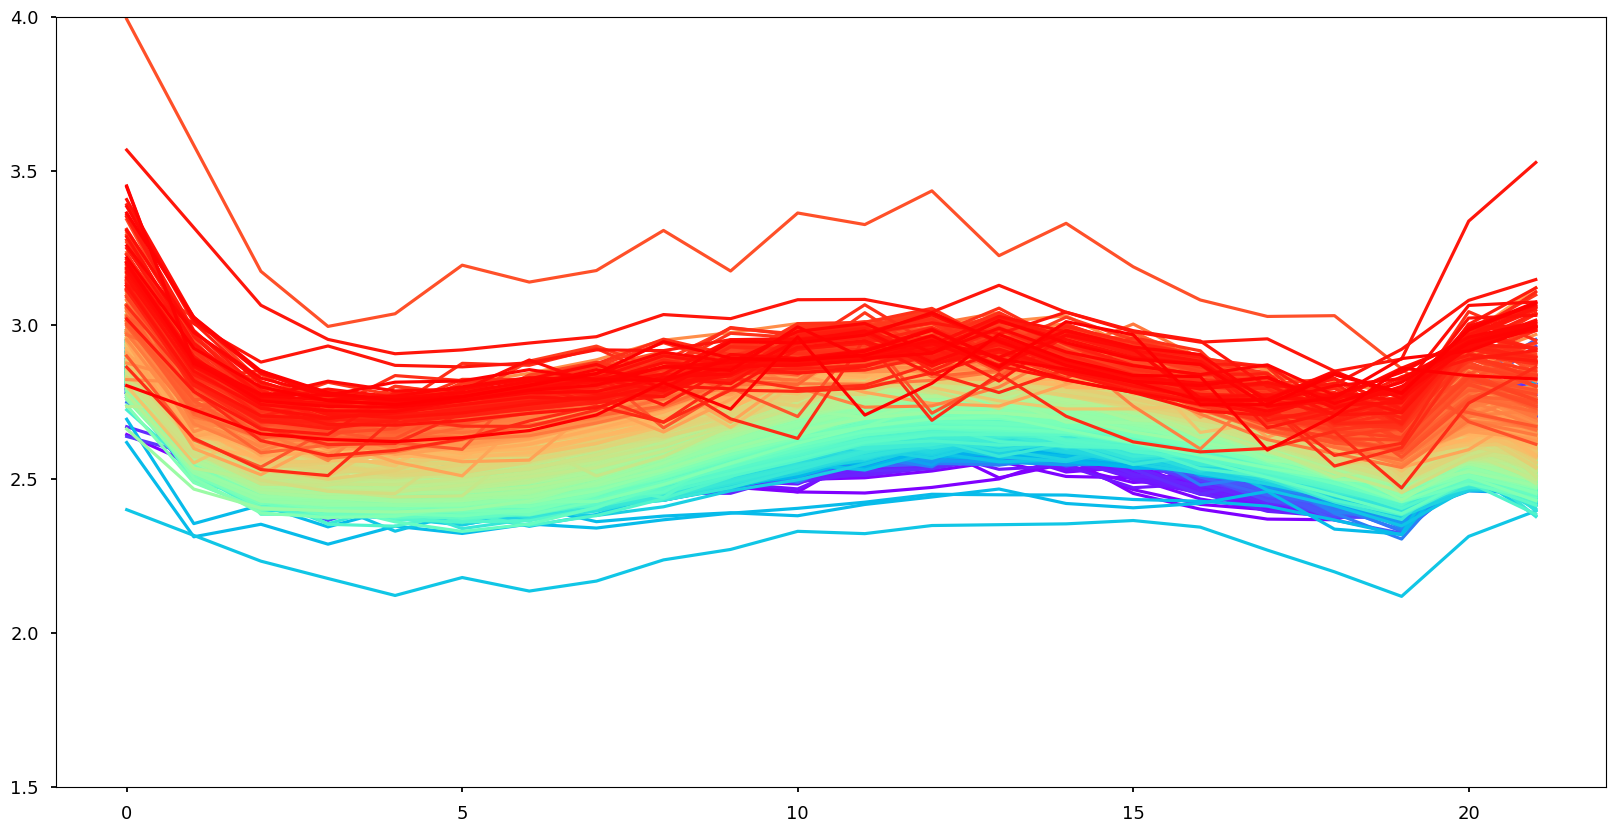

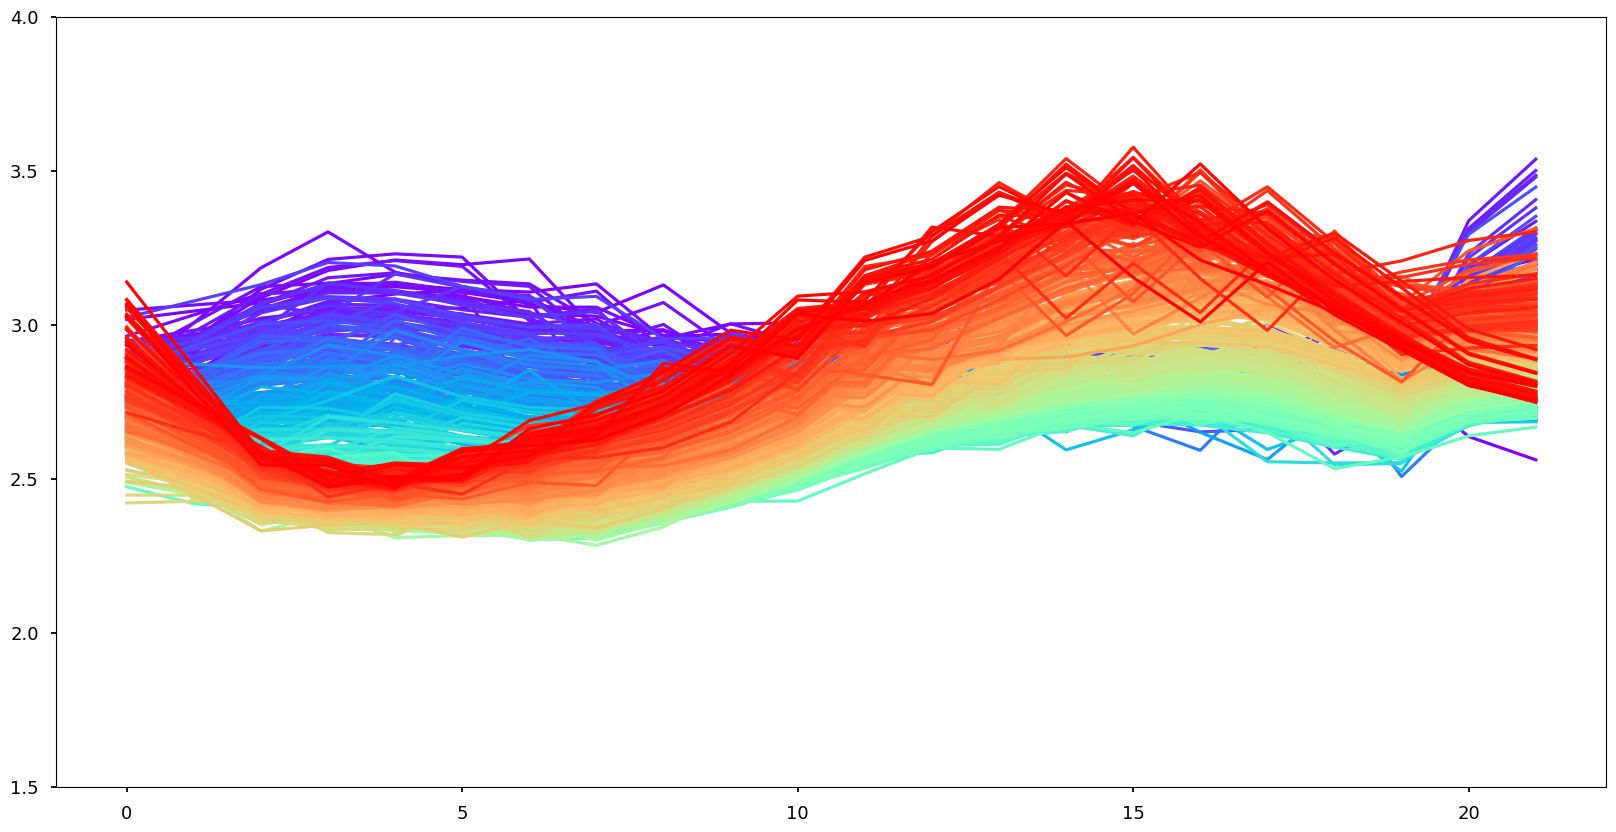

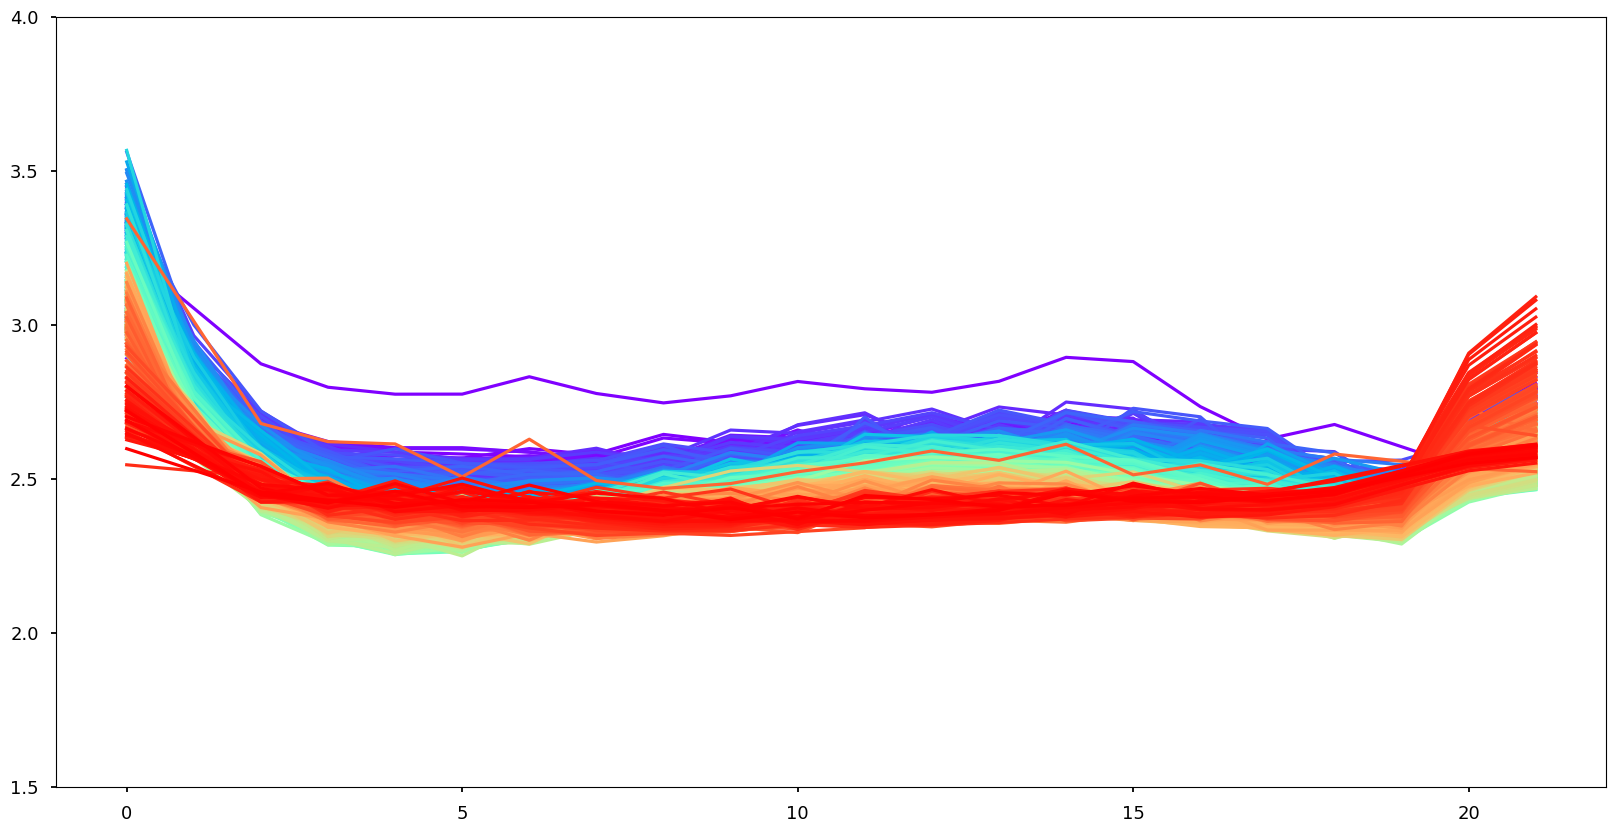

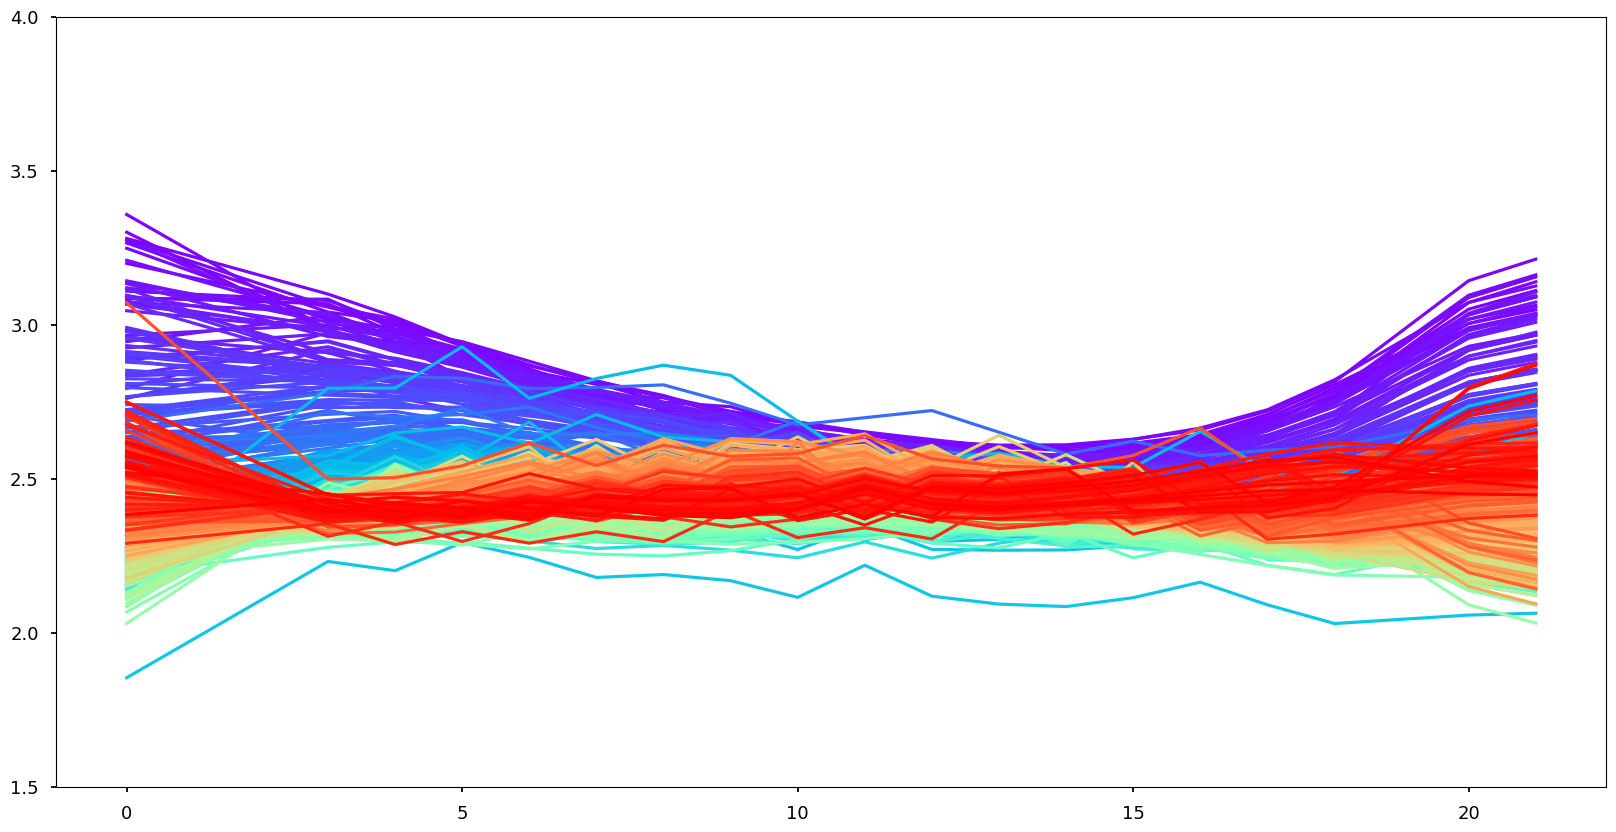

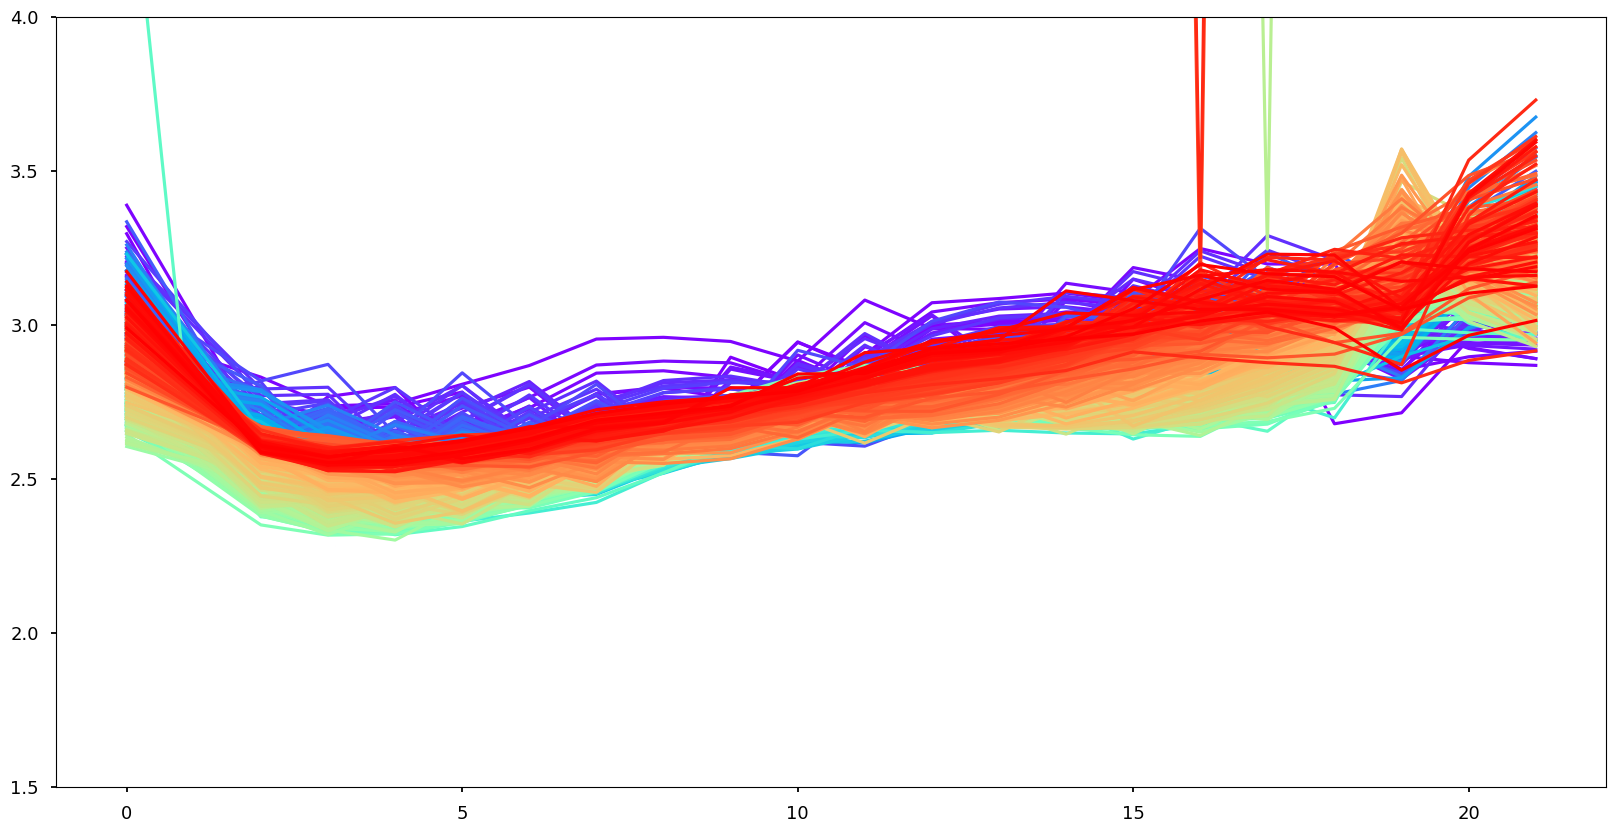

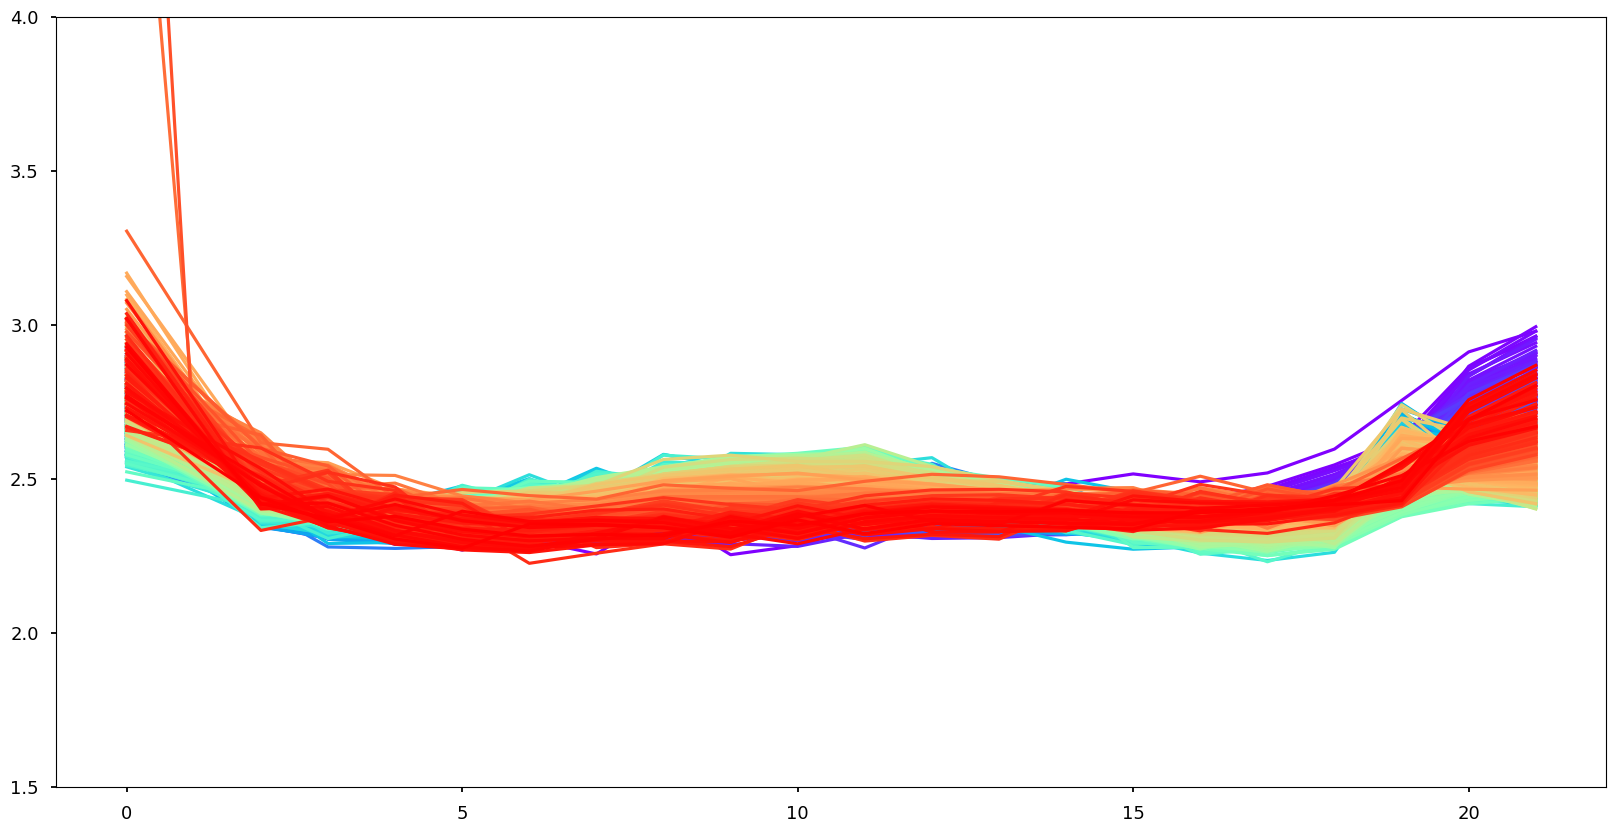

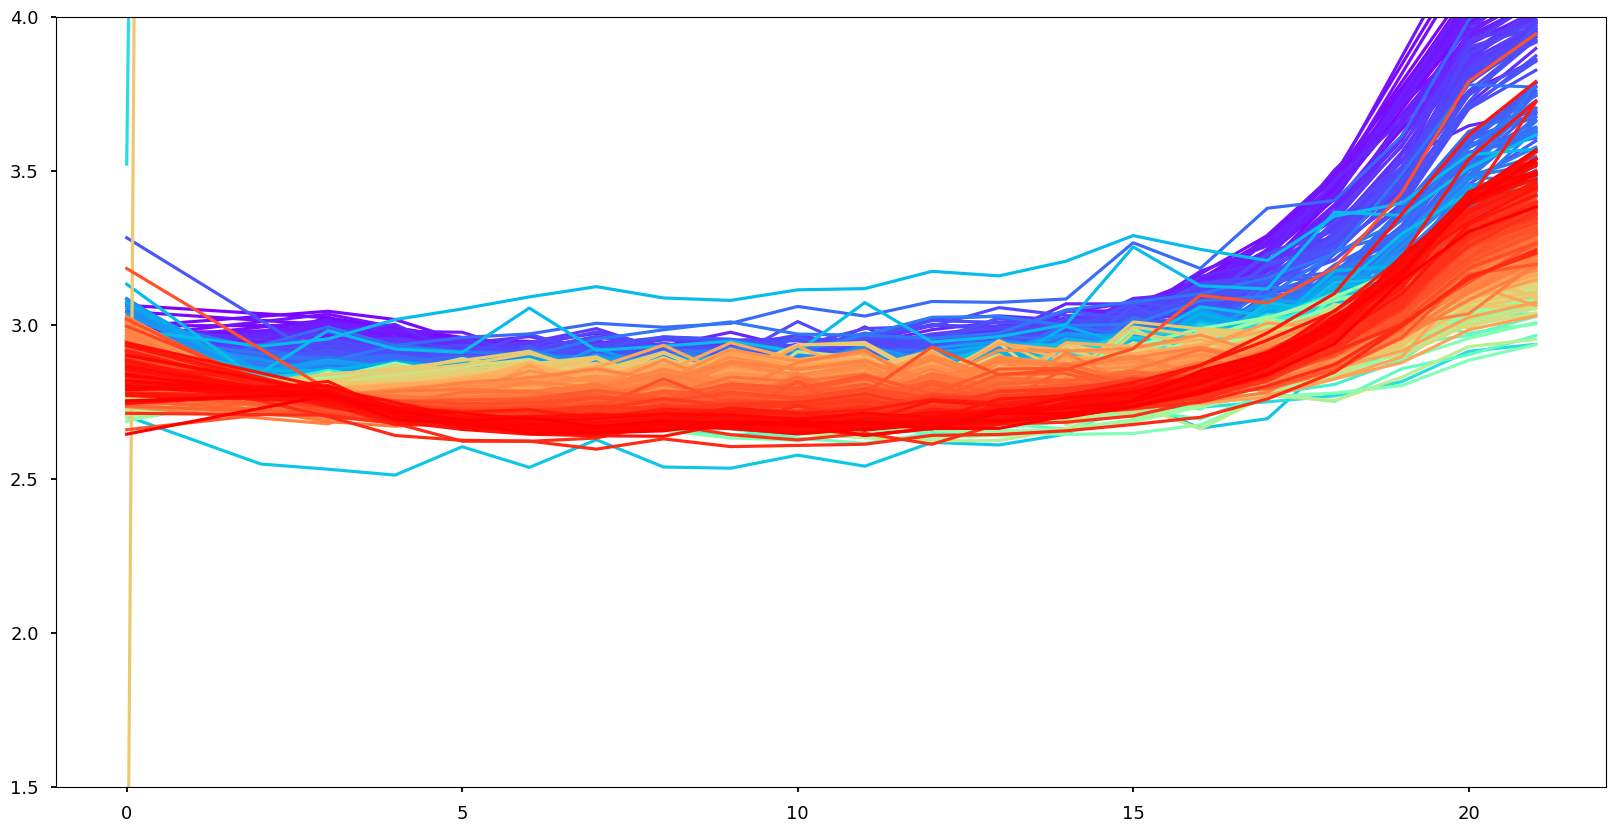

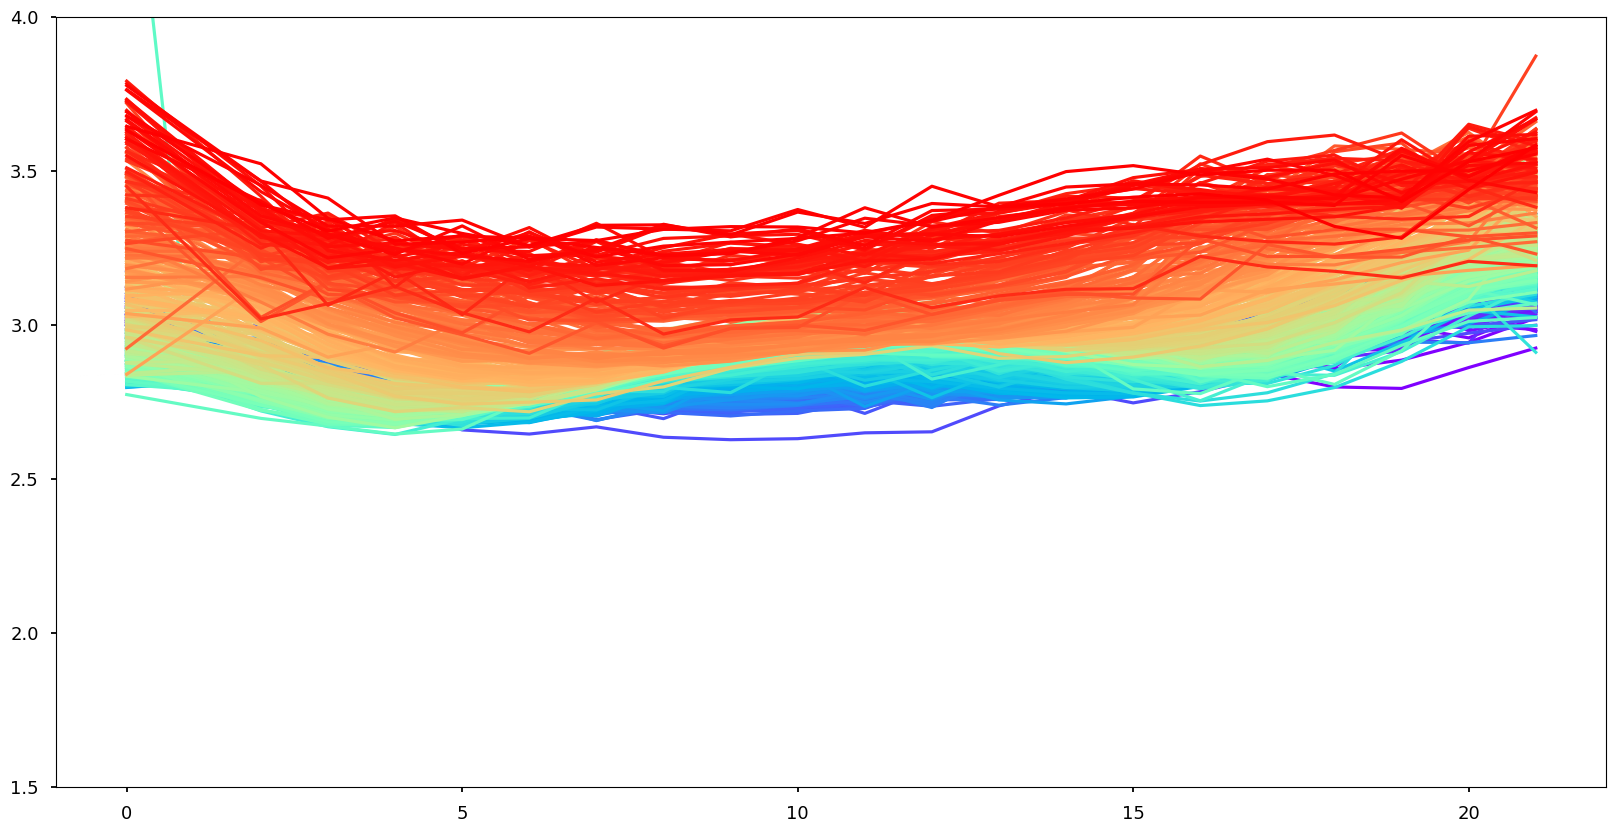

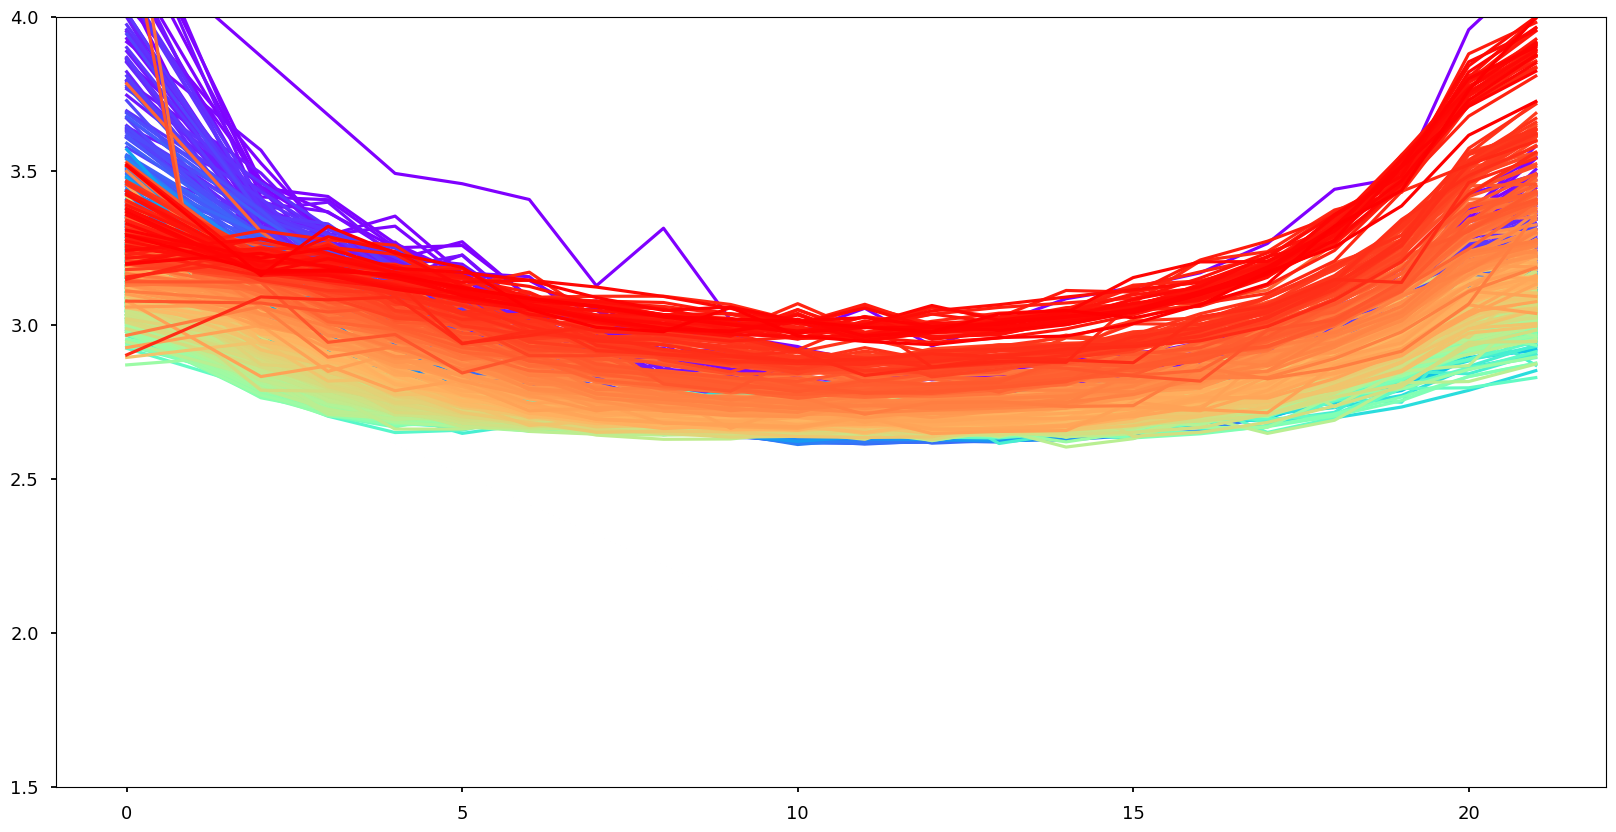

In [6]:
mwidth_paths = []
for flat in masters_flat.to_dict("records"):
    camera = flat["camera"]
    
    lamp = MASTER_CON_LAMPS[camera[0]]
    if lamp == "ldls":
        counts_threshold = 20
    elif lamp == "quartz":
        counts_threshold = 1000
    
    # define master continuum exposure path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"mflat_{lamp}", camera=camera)
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    # define master width path
    mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
    mwidth_paths.append(mwidth_path)

    # if os.path.isfile(mwidth_path):
    #     print(f"skipping {mwidth_path}, file already exist")
    #     continue
    
    # width peak of fibers
    # imageMethod.traceFWHM_drp(in_image=mflat_path, in_trace=mtrace_path, out_fwhm=mwidth_path, steps=500, coadd=10,
    #                         threshold_flux=counts_threshold, blocks=640, poly_disp=4, parallel=0)
    widths, masks = imageMethod.traceFWHM_drp(in_image=mflat_path, in_trace=mtrace_path, out_fwhm=mwidth_path, steps=200, coadd=20,
                            threshold_flux=counts_threshold, blocks=30, poly_disp=4, parallel=0, init_fwhm=4, clip="1.0,4.0")

    pixels = np.arange(widths.shape[1])
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    for i in range(648):
        if masks[i].all(): continue
        ax.plot(pixels, widths[i], color=plt.cm.rainbow(i/648))
    ax.set_ylim(1.5,4)

# cache new masters metadata into HDF5 files
# new_masters = md.extract_metadata(frames_paths=mwidth_paths)
# md.add_masters(new_masters)

In [7]:
# from scipy import interpolate


# fwhm = widths
# mask = width_masks

# select_steps = fwhm != 0.0

# f_data = interpolate.interp1d(axis[select_steps], fwhm[:, select_steps], kind="linear", axis=1, bounds_error=False, fill_value=fwhm[:, select_steps][:, [0, -1]])
# f_mask = interpolate.interp1d(axis[select_steps], mask[:, select_steps], kind="nearest", axis=1, bounds_error=False, fill_value=0)
# fwhm = f_data(axis)
# mask = f_mask(axis).astype(bool)

In [8]:
# import numpy
# import matplotlib.pyplot as plt


# img = imageMethod.loadImage(mflat_path)
# img.setData(data=numpy.nan_to_num(img._data), error=numpy.nan_to_num(img._error))

# median_box, median_cross = 10, 1
# if median_box != 0 or median_cross != 0:
#     median_box = max(median_box, 1)
#     median_cross = max(median_cross, 1)
#     img = img.medianImg((median_cross, median_box))


# plt.plot(img.getSlice(200, axis="y")._error.tolist(), lw=0.6, color="0.7")
# plt.plot(img.getSlice(20, axis="y")._error.tolist(), lw=1)